# Pattern recognition in birdsong production

In [1]:
import numpy               as np
import matplotlib.pyplot   as plt
from mpl_toolkits.mplot3d  import Axes3D
from ripser                import Rips
from src.distance          import *
from src.dynamical_systems import *

### Time series

Load the record of the air sac pressure of a canary during singing.

In [2]:
s = np.loadtxt('data/pressure.txt')

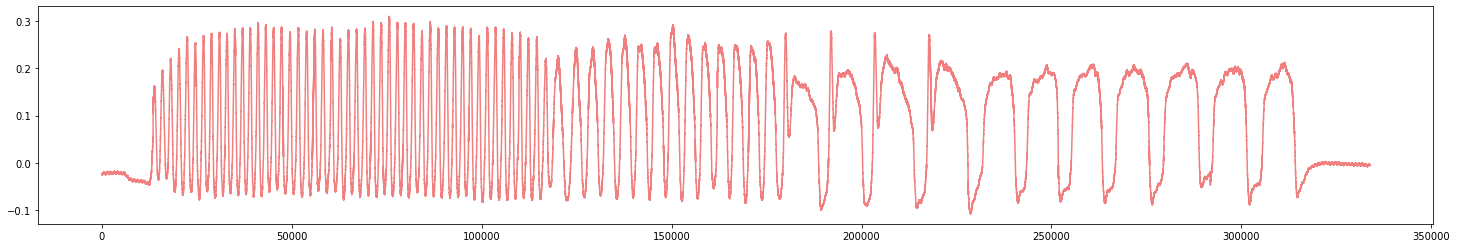

In [3]:
plt.figure(figsize=(25,4))
plt.plot(s, color = 'lightcoral');

In [4]:
len(s)

333871

### Delay embedding

We compute the delay embedding of this time series

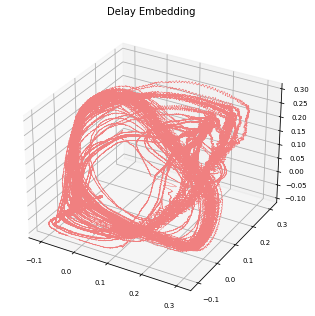

In [5]:
T =500 # time delay
D = 3  # embedding dimension
embedding = delay_embedding(s, T, D)
plot_trajectories(embedding[0], embedding[1], embedding[2], 'Delay Embedding', 'line')

We consider a subsample of ~ 3000 points of the original pointcloud (~ 300000 points)

In [6]:
data = np.column_stack([embedding[0], embedding[1], embedding[2]])
subsample = voxel_down_sample(np.array(data), 0.015)
len(subsample)

3111

### Persistence diagram 

We compute the persistence diagram of the subsample usng Fermat distance.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


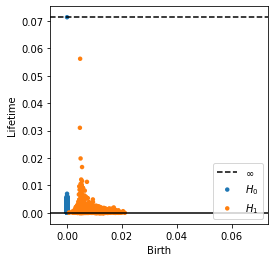

In [7]:
rips = Rips()
diagrams = rips.fit_transform(compute_fermat_distance_D(subsample, 1.5, 100), distance_matrix = True)
rips.plot(diagrams, lifetime=True)

An interpretation of the four salient generators is below.

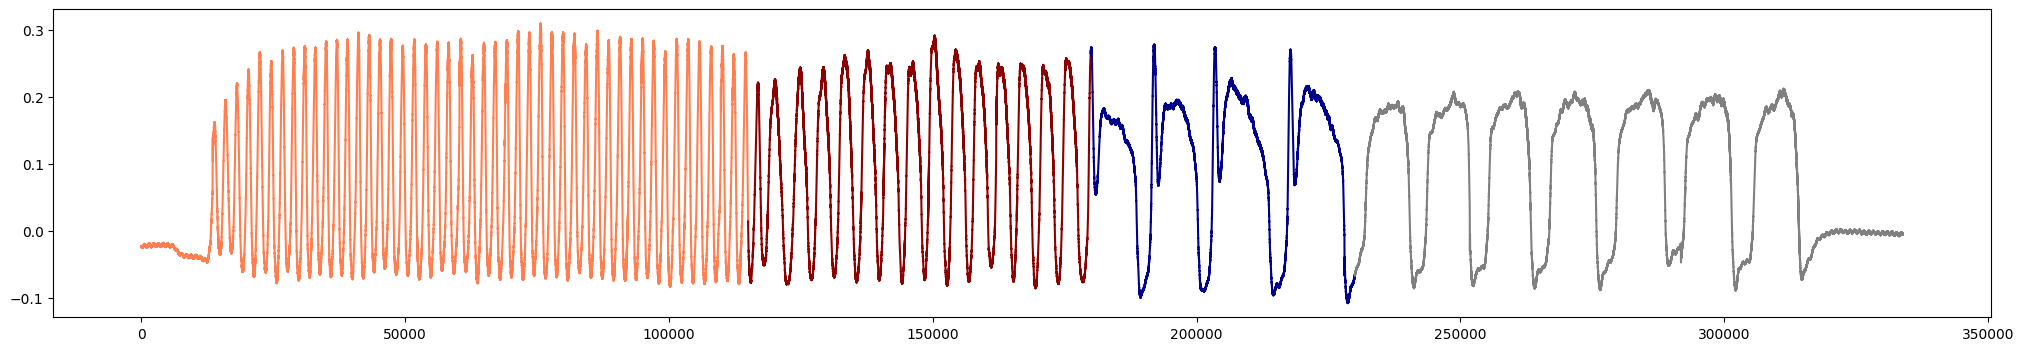

In [8]:
cuts= [0,115000, 180000, 230000, len(s)]
color = ['coral', 'darkred', 'darkblue', 'grey']

plt.figure(figsize=(25,4))
for i in range(4):
    plt.plot(range(cuts[i],cuts[i+1]), s[cuts[i]:cuts[i+1]], color = color[i])
plt.show()

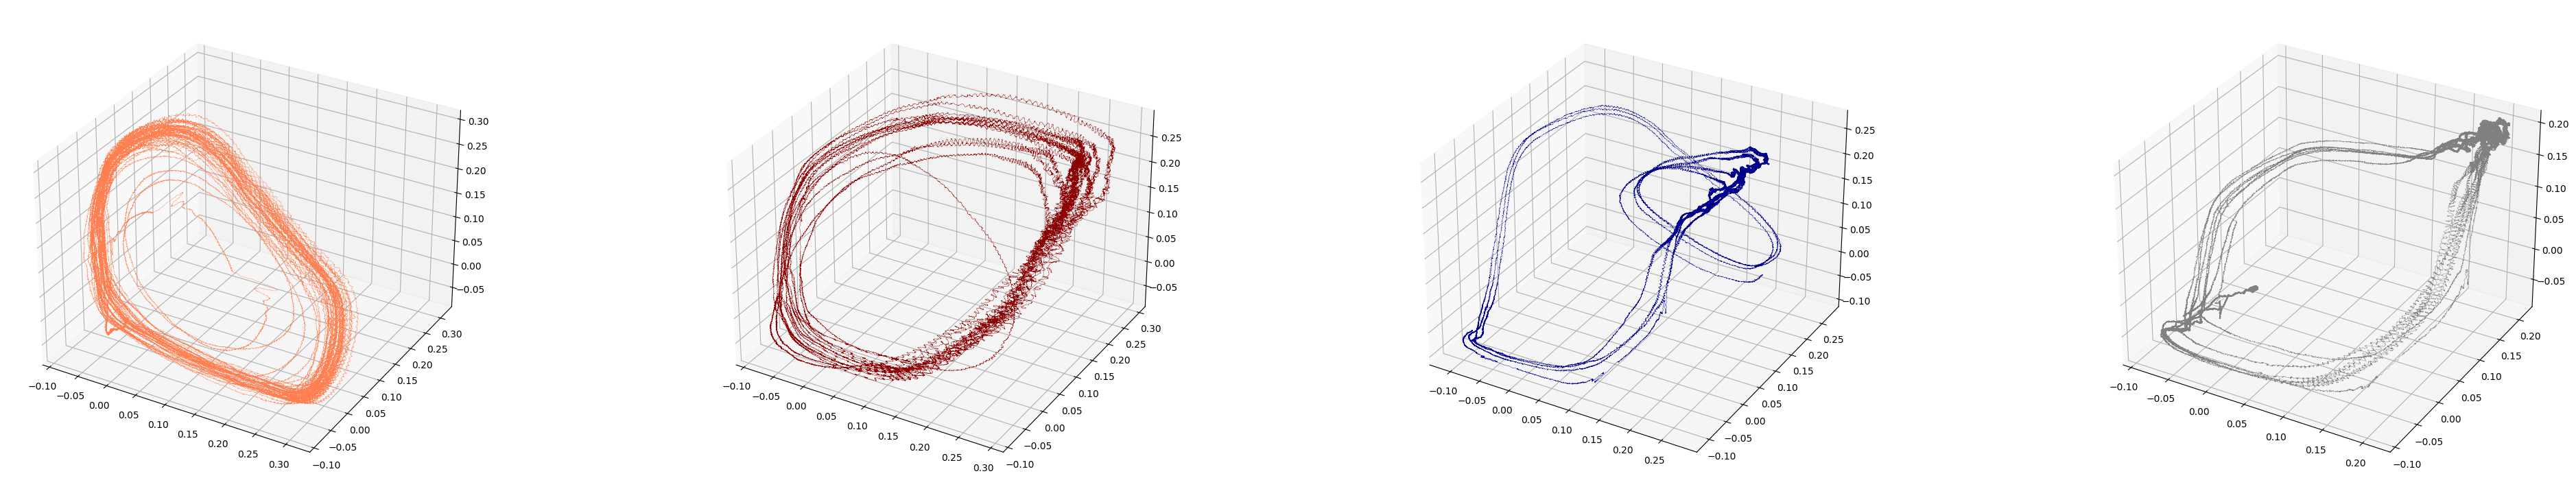

In [9]:
fig = plt.figure(figsize=(50,9))
subplot = [111,112,113,114]
T = 500
d = 3

for i in range(4):
    X = delay_embedding(s[cuts[i]:cuts[i+1]], T, d)
    ax = fig.add_subplot(1,4,i+1, projection = '3d')
    ax.plot(X[0], X[1], X[2], lw=0.3, color = color[i])
    plt.tick_params(labelsize=10)
plt.show()

If we use instead Euclidean distance, the persistence diagram cannot be interpreted clearly.

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


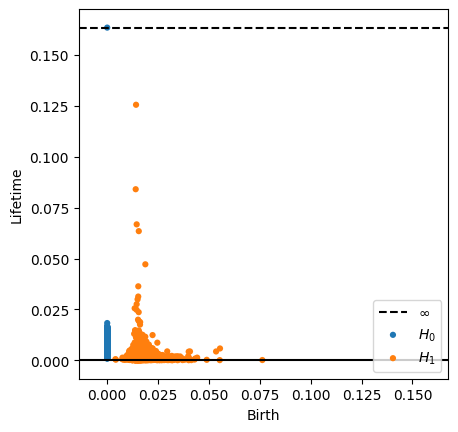

In [10]:
rips = Rips()
diagrams2 = rips.fit_transform(subsample)
rips.plot(diagrams2, lifetime=True)